### This project is an SQL exercise. The stakeholder is the management of a fictional company called Chinook which is an online music store. They sell music by album and by track. We will attempt to answer several questions by creating appropriate SQL queries.

First load the data and look at the schema.

In [3]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

In [9]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table", "view")

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


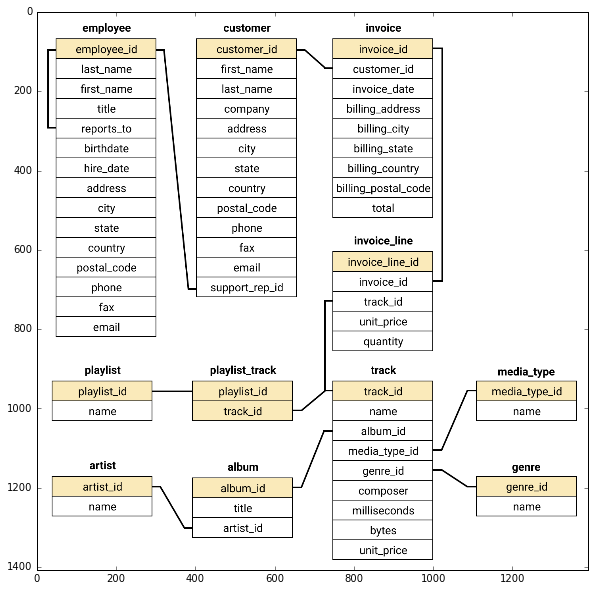

In [22]:
# Print database schema for reference
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline 

schema = mpimg.imread('chinook-schema.png')
fig = plt.figure(figsize=(10,10))
plt.imshow(schema)

The first task it to figure out which genres sell the most in the US. We have been given 4 different genres (Hip-Hop, Punk, Pop, Blues) of which we need to identify 3 recommendations of which types of albums to purchase based on sales.

In [56]:
%%sql
SELECT 
    g.name genre,
    COUNT(i.invoice_id) num_tracks_sold,
    ROUND(CAST(COUNT(i.invoice_id) AS float) / (SELECT COUNT(il.track_id) FROM invoice i INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id WHERE i.billing_country = "USA"), 2) perc_sold
FROM track t
INNER JOIN genre g ON g.genre_id = t.genre_id
INNER JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
INNER JOIN customer c ON c.customer_id = i.customer_id
WHERE c.country = "USA"
GROUP BY genre
ORDER BY num_tracks_sold DESC

Done.


genre,num_tracks_sold,perc_sold
Rock,561,0.53
Alternative & Punk,130,0.12
Metal,124,0.12
R&B/Soul,53,0.05
Blues,36,0.03
Alternative,35,0.03
Latin,22,0.02
Pop,22,0.02
Hip Hop/Rap,20,0.02
Jazz,14,0.01


Judging from current sales, Punk and Blues are clear picks from our 4 choices. The final two genres, Pop and Hip-Hop, are very close with Pop slightly outselling Hip-Hop. The 3 genres to go with are  Punk, Blues, and Pop.

In [38]:
%%sql
SELECT 
    c.support_rep_id sales_support_agent,
    e.first_name || " " || e.last_name name,
    e.hire_date,
    e.birthdate,
    2017 - e.birthdate age,
    ROUND(SUM(i.total), 2) total_sales
FROM employee e 
INNER JOIN customer c ON e.employee_id = c.support_rep_id
INNER JOIN invoice i on c.customer_id = i.customer_id
WHERE title = "Sales Support Agent"
GROUP BY sales_support_agent

Done.


sales_support_agent,name,hire_date,birthdate,age,total_sales
3,Jane Peacock,2017-04-01 00:00:00,1973-08-29 00:00:00,44,1731.51
4,Margaret Park,2017-05-03 00:00:00,1947-09-19 00:00:00,70,1584.0
5,Steve Johnson,2017-10-17 00:00:00,1965-03-03 00:00:00,52,1393.92


Sales agent # 3, Jane Peacock, is the top seller. It doesn't seem like age is a big deciding factor as Margaret Park is the next best seller and she is significanly older than the other two. Time at the company may be a contributing factor to performance. Those who have been at the company longer have better sales numbers.

Next we will analyze sales data by country. In particular, the total number of customers for each country, the total value of sales, average value of sales per customer, and average order value. Countries with only one unique customer will be grouped into "Other".

In [25]:
%%sql
WITH 
    invoice_data AS
        (
        SELECT
            CASE
                WHEN COUNT(DISTINCT c.customer_id) = 1 THEN "Other"
                ELSE country
            END AS country,
            AVG(i.total) avg_order_value,
            SUM(i.total) total_sales,
            SUM(i.total) / COUNT(DISTINCT c.customer_id) avg_sales_per_cust,
            COUNT(DISTINCT c.customer_id) num_cust
        FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        GROUP BY c.country
        ),
        grouped_invoice_data AS
        (
        SELECT
            id.country,
            SUM(id.num_cust) num_cust,
            ROUND(SUM(id.total_sales), 2) total_sales,
            ROUND(AVG(id.avg_sales_per_cust), 2) avg_sales_per_cust,
            ROUND(AVG(id.avg_order_value), 2) avg_order_value
        FROM invoice_data id
        GROUP BY country
        ORDER BY total_sales DESC
        )
    
SELECT 
    country,
    num_cust,
    total_sales,
    avg_sales_per_cust,
    avg_order_value
FROM 
    (
    SELECT
        gid.*,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
            END AS sort
    FROM grouped_invoice_data gid
    ORDER BY sort
    )

Done.


country,num_cust,total_sales,avg_sales_per_cust,avg_order_value
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
Czech Republic,2,273.24,136.62,9.11
United Kingdom,3,245.52,81.84,8.77
Portugal,2,185.13,92.57,6.38
India,2,183.15,91.57,8.72
Other,15,1094.94,73.0,7.45


It seems that the Czech Republic, Germany, and the UK have the highest average order value and my present an opportunity. However, while sales are much lower in Portugal and India, both countries have very high sales per customer, even if they make lower value purchases on average. There may also be an opportunity in those two countries if Chinook can increase their customer base but maintian the high average sales per customer.

Next we are tasked with assessing whether customers prefer to purchase albums or individual tracks. Excluding cases where albumns only have 1 or 2 tracks and cases where customers might purchase an album as well as individual tracks, we must the number of invoices with album purchases and the number of invoices with track purchases.

In [74]:
%%sql
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) num_purchases,
    CAST(COUNT(invoice_id) AS float) / (SELECT COUNT(invoice_id) FROM invoice) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
            THEN "YES"
            ELSE "NO"
        END AS album_purchase
    FROM invoice_first_track ifs
    )
GROUP BY album_purchase

Done.


album_purchase,num_purchases,percent
NO,500,0.8143322475570033
YES,114,0.18566775244299674


It seems most customers prefer to shop for individual tracks. A shift towards only purchasing popular tracks for the store may help lower the companies costs while keeping to customer preferences.

Finally, which artists have the broadest appeal and appear in the most playlists? We will just show the top 10.

In [75]:
%%sql
WITH artist_freq AS
    (
    SELECT 
        p.playlist_id playlist,
        t.name track,
        at.name artist
    FROM playlist p 
    INNER JOIN playlist_track pt ON pt.playlist_id = p.playlist_id
    INNER JOIN track t ON t.track_id = pt.track_id
    INNER JOIN album a ON a.album_id = t.album_id
    INNER JOIN artist at ON at.artist_id = a.artist_id
    )
    
SELECT
    artist,
    COUNT(DISTINCT playlist) playlist_freq
FROM artist_freq
GROUP BY artist
ORDER BY playlist_freq DESC
LIMIT 10

Done.


artist,playlist_freq
Eugene Ormandy,7
Academy of St. Martin in the Fields & Sir Neville Marriner,6
Berliner Philharmoniker & Herbert Von Karajan,6
English Concert & Trevor Pinnock,6
The King's Singers,6
"Academy of St. Martin in the Fields, Sir Neville Marriner & Thurston Dart",5
Adrian Leaper & Doreen de Feis,5
Alberto Turco & Nova Schola Gregoriana,5
Antal Doráti & London Symphony Orchestra,5
Barry Wordsworth & BBC Concert Orchestra,5
